In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import filters, segmentation, morphology

In [2]:
def cargar_y_preprocesar(imagen_path):
    """Carga y preprocesa la imagen"""
    imagen = cv2.imread(imagen_path)
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Reducción de ruido
    imagen_suavizada = cv2.medianBlur(imagen_gris, 5)

    return imagen_rgb, imagen_gris, imagen_suavizada

In [3]:
def segmentacion_umbral_adaptativo(imagen_gris):
    """Segmentación usando umbral adaptativo para áreas dañadas"""
    # Umbral adaptativo para detectar áreas oscuras (grietas, manchas)
    umbral_adapt = cv2.adaptiveThreshold(
        imagen_gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Operaciones morfológicas para limpiar la máscara
    kernel = np.ones((3,3), np.uint8)
    mascara_limpia = morphology.opening(umbral_adapt, kernel)
    mascara_limpia = morphology.closing(mascara_limpia, kernel)

    return mascara_limpia

In [4]:
def segmentacion_color(imagen_rgb):
    """Segmentación basada en diferencias de color"""
    # Convertir a diferentes espacios de color
    imagen_hsv = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2HSV)
    imagen_lab = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2LAB)

    # Detectar áreas descoloridas o decoloradas
    # En espacio LAB, el canal L representa luminosidad
    L = imagen_lab[:,:,0]

    # Umbralizar para áreas muy oscuras o muy claras
    mascara_oscura = L < 50
    mascara_clara = L > 200

    mascara_color = np.logical_or(mascara_oscura, mascara_clara)

    return mascara_color.astype(np.uint8) * 255

In [5]:
def deteccion_grietas(imagen_gris):
    """Detección específica de grietas y líneas de daño"""
    # Detección de bordes
    bordes = cv2.Canny(imagen_gris, 50, 150)

    # Transformada de Hough para líneas
    lineas = cv2.HoughLinesP(bordes, 1, np.pi/180, threshold=50,
                           minLineLength=30, maxLineGap=10)

    # Crear máscara de líneas
    mascara_lineas = np.zeros_like(imagen_gris)
    if lineas is not None:
        for linea in lineas:
            x1, y1, x2, y2 = linea[0]
            cv2.line(mascara_lineas, (x1, y1), (x2, y2), 255, 2)

    return mascara_lineas

In [6]:
def segmentacion_kmeans(imagen_rgb, n_clusters=4):
    """Segmentación usando K-means clustering"""
    # Redimensionar la imagen para K-means
    pixel_values = imagen_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Aplicar K-means
    criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, etiquetas, centros = cv2.kmeans(pixel_values, n_clusters, None,
                                     criterio, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convertir de vuelta a formato de imagen
    centros = np.uint8(centros)
    imagen_segmentada = centros[etiquetas.flatten()]
    imagen_segmentada = imagen_segmentada.reshape(imagen_rgb.shape)

    # Identificar el cluster más oscuro (probable daño)
    luminosidad_centros = [np.mean(centro) for centro in centros]
    cluster_danado = np.argmin(luminosidad_centros)

    mascara_kmeans = (etiquetas.reshape(imagen_rgb.shape[:2]) == cluster_danado).astype(np.uint8) * 255

    return mascara_kmeans, imagen_segmentada

In [7]:
def segmentacion_combinada(imagen_path):
    """Enfoque combinado para mejor precisión"""
    # Cargar y preprocesar
    imagen_rgb, imagen_gris, imagen_suavizada = cargar_y_preprocesar(imagen_path)

    # Aplicar diferentes técnicas
    mascara_umbral = segmentacion_umbral_adaptativo(imagen_suavizada)
    mascara_color = segmentacion_color(imagen_rgb)
    mascara_grietas = deteccion_grietas(imagen_suavizada)
    mascara_kmeans, _ = segmentacion_kmeans(imagen_rgb)

    # Combinar máscaras
    mascara_combinada = cv2.bitwise_or(mascara_umbral, mascara_color)
    mascara_combinada = cv2.bitwise_or(mascara_combinada, mascara_grietas)
    mascara_combinada = cv2.bitwise_or(mascara_combinada, mascara_kmeans)

    # Post-procesamiento
    kernel = np.ones((5,5), np.uint8)
    mascara_combinada = morphology.opening(mascara_combinada, kernel)
    mascara_combinada = morphology.closing(mascara_combinada, kernel)

    # Eliminar pequeños componentes
    mascara_final = eliminar_pequenos_componentes(mascara_combinada, min_size=100)

    return mascara_final, imagen_rgb

def eliminar_pequenos_componentes(mascara, min_size=100):
    """Elimina componentes pequeños de la máscara"""
    num_componentes, etiquetas, stats, _ = cv2.connectedComponentsWithStats(mascara, connectivity=8)

    mascara_limpia = np.zeros_like(mascara)
    for i in range(1, num_componentes):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mascara_limpia[etiquetas == i] = 255

    return mascara_limpia

In [8]:
def visualizar_resultados(imagen_original, mascaras, titulos):
    """Visualiza la imagen original y las máscaras de segmentación"""
    plt.figure(figsize=(15, 10))

    # Imagen original
    plt.subplot(2, 3, 1)
    plt.imshow(imagen_original)
    plt.title('Imagen Original')
    plt.axis('off')

    # Máscaras
    for i, (mascara, titulo) in enumerate(zip(mascaras, titulos)):
        plt.subplot(2, 3, i+2)
        plt.imshow(mascara, cmap='gray')
        plt.title(titulo)
        plt.axis('off')

    # Superposición
    plt.subplot(2, 3, 6)
    imagen_superpuesta = imagen_original.copy()
    mascara_color = np.zeros_like(imagen_original)
    mascara_color[mascaras[0] > 0] = [255, 0, 0]  # Rojo para áreas dañadas
    cv2.addWeighted(imagen_superpuesta, 0.7, mascara_color, 0.3, 0, imagen_superpuesta)
    plt.imshow(imagen_superpuesta)
    plt.title('Áreas Dañadas Detectadas')
    plt.axis('off')

    plt.tight_layout()
    plt.show()



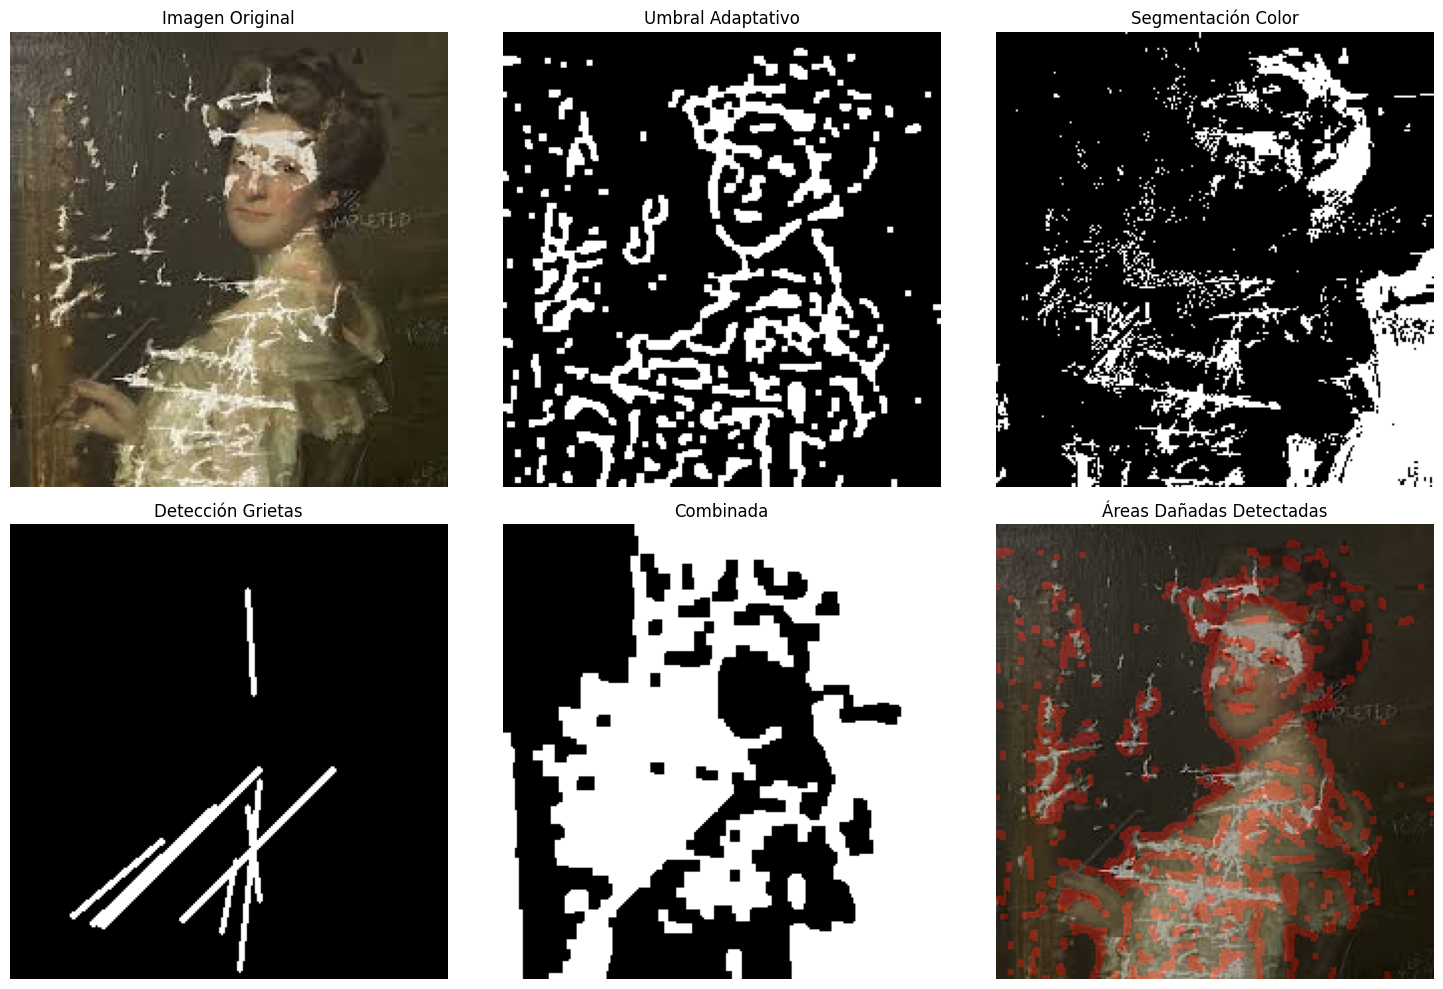

In [10]:
imagen_path = "pinturas/danio01.jpeg"

    # Segmentación
mascara_final, imagen_original = segmentacion_combinada(imagen_path)

    # Técnicas individuales para comparación
_, img_gris, img_suav = cargar_y_preprocesar(imagen_path)
mascara_umbral = segmentacion_umbral_adaptativo(img_suav)
mascara_color = segmentacion_color(imagen_original)
mascara_grietas = deteccion_grietas(img_suav)

    # Visualizar
mascaras = [mascara_umbral, mascara_color, mascara_grietas, mascara_final]
titulos = ['Umbral Adaptativo', 'Segmentación Color', 'Detección Grietas', 'Combinada']

visualizar_resultados(imagen_original, mascaras, titulos)

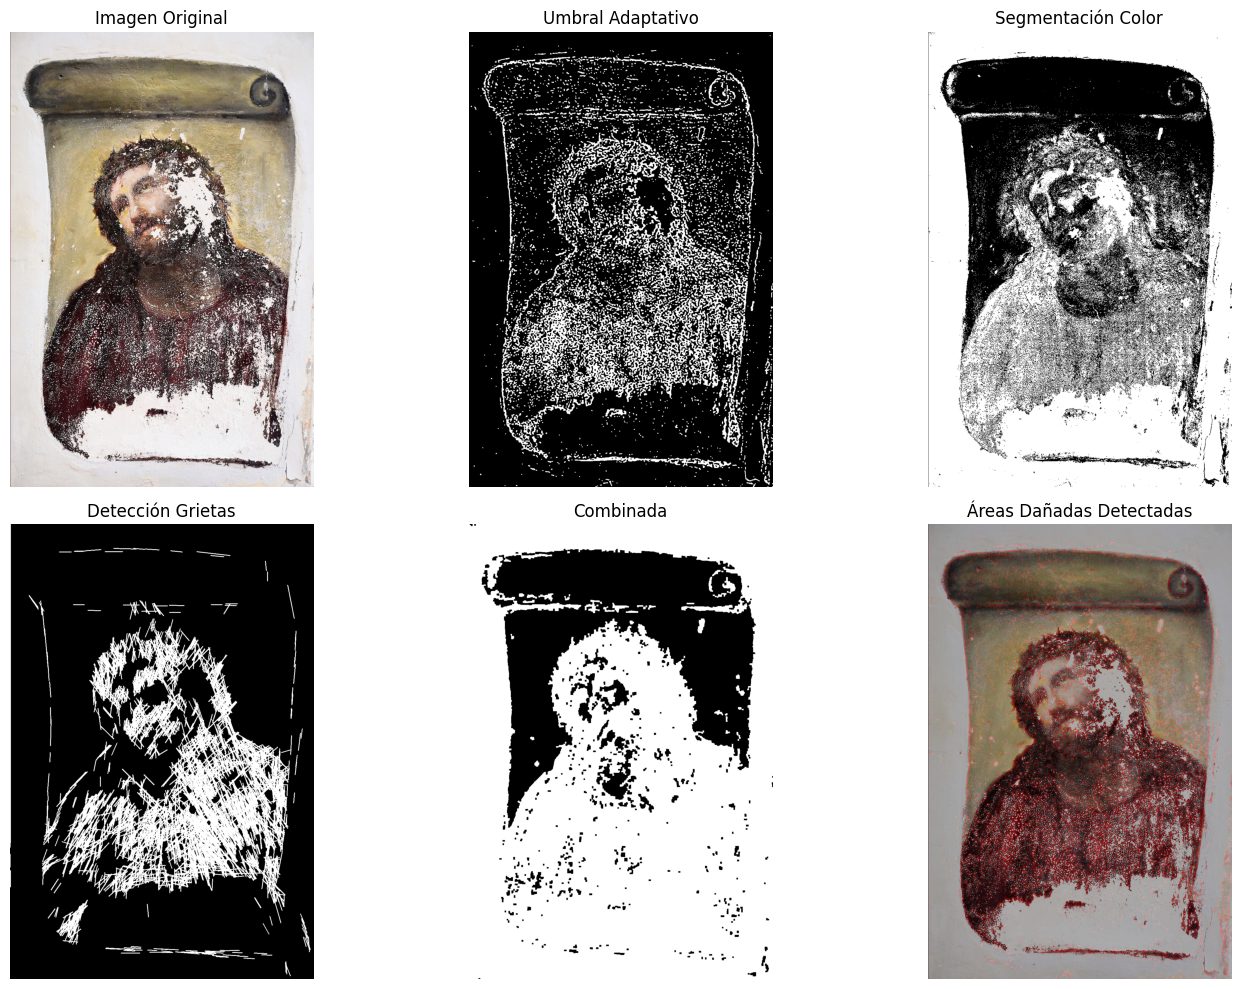

In [11]:
imagen_path = "pinturas/danio02.jpg"

    # Segmentación
mascara_final, imagen_original = segmentacion_combinada(imagen_path)

    # Técnicas individuales para comparación
_, img_gris, img_suav = cargar_y_preprocesar(imagen_path)
mascara_umbral = segmentacion_umbral_adaptativo(img_suav)
mascara_color = segmentacion_color(imagen_original)
mascara_grietas = deteccion_grietas(img_suav)

    # Visualizar
mascaras = [mascara_umbral, mascara_color, mascara_grietas, mascara_final]
titulos = ['Umbral Adaptativo', 'Segmentación Color', 'Detección Grietas', 'Combinada']

visualizar_resultados(imagen_original, mascaras, titulos)